In [47]:
import numpy as np

class Neuron:
    def __init__(self, num_weights, lr, activation="sigmoid"):
        self.weights = np.zeros(num_weights)
        self.bias = np.zeros(1)
        self.input_vector = None
        self.net = None
        self.out = None
        self.lr = lr
        self.momentum = 0.9
        self.activation = activation
        self.last_gradients_weights, self.last_gradients_bias = None, None
        self.initialize()
    
    def forward(self, input_vector):
        """Relu activation"""
        self.input_vector = input_vector
        assert self.input_vector.shape == self.weights.shape
        self.net = np.dot(self.weights, self.input_vector) + self.bias
        if self.activation == "sigmoid":
            self.out = 1 / (1 + np.exp(-1 * self.net))
        else:
            raise NotImplementedError("not existent")
        return self.out
    
    def backward(self, gradients, learning_rate):
        """Compute gradients for weights and bias based on collected gradients"""
        self.lr = learning_rate
        if self.activation == "sigmoid":
            dout_dnet = self.out * (1 - self.out)
        else:
            raise NotImplementedError("not existent")
        gradients_weights = gradients * dout_dnet * self.input_vector
        gradient_bias = gradients * dout_dnet * 1
        self.update_parameters(gradients_weights, gradient_bias)
        #print("Gradients:", gradients_weights, gradient_bias)
        return gradients_weights
    
    def update_parameters(self, gradients_weights, gradient_bias):
        # GD w/ Momentum
        if self.last_gradients_weights is not None and self.last_gradients_bias is not None:
            self.weights -= self.momentum * self.last_gradients_weights + (1 - self.momentum) * self.lr * gradients_weights
            self.bias -= self.momentum * self.last_gradients_bias + (1 - self.momentum) * self.lr * gradient_bias
        else:
            self.weights -= self.lr * gradients_weights
            self.bias -= self.lr * gradient_bias
        self.last_gradients_weights, self.last_gradients_bias = gradients_weights, gradient_bias
    
    def initialize(self):
        if self.activation == "sigmoid":
            self.weights = np.random.normal(0.0, 2.0 / self.weights.shape[0], self.weights.shape[0])
            self.bias = np.random.normal(0.0, 1.0, 1)
        else:
            raise NotImplementedError("")
            
            
class Layer:
    def __init__(self, input_size, num_neurons, lr, activation):
        self.neurons = [Neuron(num_weights=input_size, lr=lr, activation=activation) for i in range(num_neurons)]
    
    def forward(self, input_vector):
        outs = np.zeros(len(self.neurons))
        for idx, n in enumerate(self.neurons):
            outs[idx] = n.forward(input_vector)
        return outs
            
    def backward(self, gradients, learning_rate):
        gradients_to_lower = np.zeros(self.neurons[0].weights.shape[0])
        for idx, n in enumerate(self.neurons):
            gradients_weights = n.backward(gradients[idx], learning_rate)
            gradients_to_lower += gradients_weights
        return gradients_to_lower

    
class Net:
    def __init__(self, input_size, neurons_per_layer, lr=0.1):
        self.layers = list()
        for l, a in neurons_per_layer:
            self.layers.append(Layer(input_size, l, lr, a))
            input_size = l
    
    def forward(self, input_vector):
        out = input_vector
        for l in self.layers:
            out = l.forward(out)
        return out
    
    def backward(self, gradients, learning_rate):
        for idx, l in enumerate(reversed(self.layers)):
            gradients = l.backward(gradients, learning_rate)
        
            
class Loss:
    def __init__(self, name, net):
        self.name = name
        self.loss = None
        self.gradient = None
        self.y_pred, self.y_target = None, None
        self.net = net
        
    def forward(self, y_pred, y_target):
        self.y_pred, self.y_target = y_pred, y_target
        if self.name == "L2":
            self.loss = 0.5 * np.square(np.subtract(y_target, y_pred))
        else:
            raise NotImplementedError("not existent")
        return self.loss
    
    def backward(self):
        if self.name == "L2":
            self.gradient = -1 * np.subtract(self.y_target, self.y_pred)
        else:
            raise NotImplementedError("not existent")
        return self.gradient

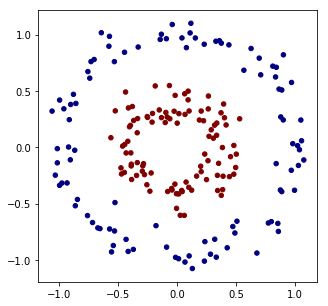

In [48]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Create data
X, y = make_circles(n_samples=200, noise=0.1, factor=0.4)

# Visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

In [49]:
epochs = 500
net = Net(input_size=2, neurons_per_layer=[(5, "sigmoid"), (1, "sigmoid"), (1, "sigmoid")])
l = Loss("L2", net)

for e in range(epochs):
    losses, accuracy, zero_a = list(), list(), list()
    learning_rate = 0.1
    # Shuffle data
    p = np.random.permutation(len(y))
    X, y = X[p], y[p]
    for sample_x, sample_y in zip(X, y):
        pred = net.forward(input_vector=sample_x)
        correct = 1 if ((pred < 0.5) and (sample_y < 0.5) or (pred > 0.5) and (sample_y > 0.5)) else 0
        accuracy.append(correct)
        loss = l.forward(pred, sample_y)
        losses.append(loss)
        g = l.backward()
        net.backward(gradients=g, learning_rate=learning_rate)

    if e % 5 == 0:
        #print(net.get_zero_activations())
        print("Epoch:", e, "Loss:", np.mean(losses), "Accuracy:", np.mean(accuracy))

Epoch: 0 Loss: 0.1312906670493253 Accuracy: 0.51
Epoch: 5 Loss: 0.13116314576852825 Accuracy: 0.545
Epoch: 10 Loss: 0.12638515694367813 Accuracy: 0.56
Epoch: 15 Loss: 0.12421930625704304 Accuracy: 0.55
Epoch: 20 Loss: 0.1161855213792165 Accuracy: 0.605
Epoch: 25 Loss: 0.1202887273616204 Accuracy: 0.57
Epoch: 30 Loss: 0.11949675041627728 Accuracy: 0.56
Epoch: 35 Loss: 0.11908887666344235 Accuracy: 0.565
Epoch: 40 Loss: 0.1173670940309053 Accuracy: 0.58
Epoch: 45 Loss: 0.1186102291979239 Accuracy: 0.575
Epoch: 50 Loss: 0.11576347166045065 Accuracy: 0.59
Epoch: 55 Loss: 0.11812085119466706 Accuracy: 0.585
Epoch: 60 Loss: 0.11520171669874799 Accuracy: 0.62
Epoch: 65 Loss: 0.1170526834091393 Accuracy: 0.58
Epoch: 70 Loss: 0.11225733758469471 Accuracy: 0.615
Epoch: 75 Loss: 0.1152946968215915 Accuracy: 0.565
Epoch: 80 Loss: 0.11424388008416837 Accuracy: 0.62
Epoch: 85 Loss: 0.11277745973004989 Accuracy: 0.61
Epoch: 90 Loss: 0.11338425501717396 Accuracy: 0.56
Epoch: 95 Loss: 0.110624060735494

100%|██████████| 2500/2500 [00:00<00:00, 4562.51it/s]


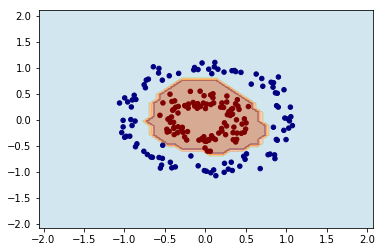

In [50]:
from tqdm import tqdm
cmap = 'Paired'
cmap = plt.get_cmap(cmap)

# Define region of interest by data limits
xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
steps = 50
x_span = np.linspace(xmin, xmax, steps)
y_span = np.linspace(ymin, ymax, steps)
xx, yy = np.meshgrid(x_span, y_span)

# Make predictions across region of interest
labels = list()
for sample_x in tqdm(np.c_[xx.ravel(), yy.ravel()]):
    labels.append(1 if net.forward(input_vector=sample_x) > 0.5 else 0)

labels = np.array(labels)

# Plot decision boundary in region of interest
z = labels.reshape(xx.shape)

fig, ax = plt.subplots()
ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

# Get predicted labels on training data and plot
ax.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

